# *Process list of ParOSol outputs*
Voxel-uFE models solved in ParOSol

Created on:  14.11.2025 <br />
Last update: 14.11.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2025
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
![](./../../fem_pipeline.png)
This notebook does:
1. Load list of ParOSol `.h5` output files
2. Calculate apparent elastic modulus from reaction forces


---
## Configuration and imports

In [1]:
import sys
# sys.path.append('./../../')

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import h5py

from ciclope.utils.postprocess import reaction_forces

## Load list of files

In [19]:
# data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/'
data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/'
file_list = 'parosol_models_ds10_and_blur.lst'
stats_file = '~/myterminus/code/supertab/stat_outputs/parosol_models_ds10_and_blur.csv'

In [4]:
# Read list of filenames from .lst file
lst_file_path = os.path.join(os.path.expanduser(data_path), file_list)

with open(lst_file_path, 'r') as f:
    file_paths = [line.strip() for line in f.readlines()]

# Replace absolute paths with data_path
file_paths = [os.path.join(os.path.expanduser(data_path), os.path.basename(fpath)) for fpath in file_paths]

print(f"Loaded {len(file_paths)} files from {file_list}")
for i, fpath in enumerate(file_paths):
    print(f"  {i+1}: {fpath}")

Loaded 15 files from parosol_models_ds10_and_blur.lst
  1: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/hr_idx0.h5
  2: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/hr_idx1.h5
  3: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/hr_idx2.h5
  4: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/hr_idx3.h5
  5: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/hr_idx4.h5
  6: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/sr_idx0.h5
  7: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/sr_idx1.h5
  8: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/sr_idx2.h5
  9: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251116_142057/results/sr_idx3.h5
  10: /home/giiori/terminus/external/tacosound

## Post-processing of FE results
### Read ParOSol output and Reaction forces

In [5]:
plane_lock_num = 10
slice_level = plane_lock_num + 1

In [59]:
# Read results for all files and store in DataFrame
import re
results_list = []

for fpath in file_paths:
    try:
        res = reaction_forces(fpath, slice_level)
        base = os.path.basename(fpath)
        # scale is prefix before first underscore (e.g., 'hr', 'sr', 'lr')
        scale = base.split('_')[0]
        # extract numeric index after 'idx'
        m = re.search(r'idx(\d+)', base)
        idx = int(m.group(1)) if m else None

        res['file'] = base
        res['idx'] = idx
        res['scale'] = scale
        res['model'] = Path(base).stem
        results_list.append(res)
    except Exception as e:
        print(f"Error processing {fpath}: {e}")

# Create DataFrame from results
df_results = pd.DataFrame(results_list)

# Normalize types: idx as integer (nullable Int64)
if 'idx' in df_results.columns:
    df_results['idx'] = pd.to_numeric(df_results['idx'], errors='coerce').astype('Int64')

df_results = df_results.rename(columns={'idx': 'patch_idx', 'scale': 'source'})
df_results['source'] = df_results['source'].str.upper()
df_results.set_index('model')

print(f"Created DataFrame with {len(df_results)} rows")
df_results.head()

Created DataFrame with 15 rows


,Z_min,Z_max,total_force,F_tot,num_nodes,num_elements,vs,nodes_z0_count,nodes_z1_count,file,patch_idx,source,model
0,7.4538,7.7568,"[0.08592136049960201, 0.15699471960974323, -0....",0.916751,705670,420531,0.0303,7160,12129,hr_idx0.h5,0,HR,hr_idx0
1,7.4538,7.7568,"[3.814371506853372, -0.9020550763647491, -18.9...",19.348700,828540,522392,0.0303,18304,7298,hr_idx1.h5,1,HR,hr_idx1
2,7.4538,7.7568,"[-0.04918517549255408, 0.1667850708986218, -0....",0.661721,782466,458907,0.0303,9988,10529,hr_idx2.h5,2,HR,hr_idx2
3,7.4538,7.7568,"[0.14898979279391178, 0.14166319499889002, -0....",0.461925,738493,431270,0.0303,2661,7045,hr_idx3.h5,3,HR,hr_idx3
4,7.4538,7.7568,"[1.233281540103286, -0.5668782556231331, -15.9...",16.039337,1279609,807861,0.0303,23544,20689,hr_idx4.h5,4,HR,hr_idx4


In [72]:
# Read stats file
stats_path = os.path.expanduser(stats_file)
df_stats = pd.read_csv(stats_path)
df_stats = df_stats.rename(columns={'bone_volume_fraction': 'BVTV'})
df_stats['model'] = None
for i, row in df_stats.iterrows():
    df_stats.at[i, 'model'] = os.path.splitext(os.path.basename(row['model_name']))[0]
# df_stats['model'] = os.path.splitext(os.path.basename(df_stats['model_name']))[0]

df_stats.set_index('model')

print(f"Loaded stats from {stats_file}")
print(f"Shape: {df_stats.shape}")
df_stats.head()

Loaded stats from ~/myterminus/code/supertab/stat_outputs/parosol_models_ds10_and_blur.csv
Shape: (15, 6)


,model_name,BVTV,position,patch_idx,source,model
0,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.030286,"([2560, 2816], [2816, 3072], [2304, 2560])",0,HR,hr_idx0
1,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.040515,"([2816, 3072], [2560, 2816], [2048, 2304])",1,HR,hr_idx1
2,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.033315,"([2816, 3072], [2816, 3072], [2304, 2560])",2,HR,hr_idx2
3,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.037302,"([3072, 3328], [2560, 2816], [1792, 2048])",3,HR,hr_idx3
4,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.051954,"([3072, 3328], [2560, 2816], [2048, 2304])",4,HR,hr_idx4


In [83]:
df_results = pd.merge(df_results, df_stats)

In [84]:
df_results.head()

,Z_min,Z_max,total_force,F_tot,num_nodes,num_elements,vs,nodes_z0_count,nodes_z1_count,file,patch_idx,source,model,model_name,BVTV,position
0,7.4538,7.7568,"[0.08592136049960201, 0.15699471960974323, -0....",0.916751,705670,420531,0.0303,7160,12129,hr_idx0.h5,0,HR,hr_idx0,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.030286,"([2560, 2816], [2816, 3072], [2304, 2560])"
1,7.4538,7.7568,"[3.814371506853372, -0.9020550763647491, -18.9...",19.348700,828540,522392,0.0303,18304,7298,hr_idx1.h5,1,HR,hr_idx1,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.040515,"([2816, 3072], [2560, 2816], [2048, 2304])"
2,7.4538,7.7568,"[-0.04918517549255408, 0.1667850708986218, -0....",0.661721,782466,458907,0.0303,9988,10529,hr_idx2.h5,2,HR,hr_idx2,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.033315,"([2816, 3072], [2816, 3072], [2304, 2560])"
3,7.4538,7.7568,"[0.14898979279391178, 0.14166319499889002, -0....",0.461925,738493,431270,0.0303,2661,7045,hr_idx3.h5,3,HR,hr_idx3,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.037302,"([3072, 3328], [2560, 2816], [1792, 2048])"
4,7.4538,7.7568,"[1.233281540103286, -0.5668782556231331, -15.9...",16.039337,1279609,807861,0.0303,23544,20689,hr_idx4.h5,4,HR,hr_idx4,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.051954,"([3072, 3328], [2560, 2816], [2048, 2304])"


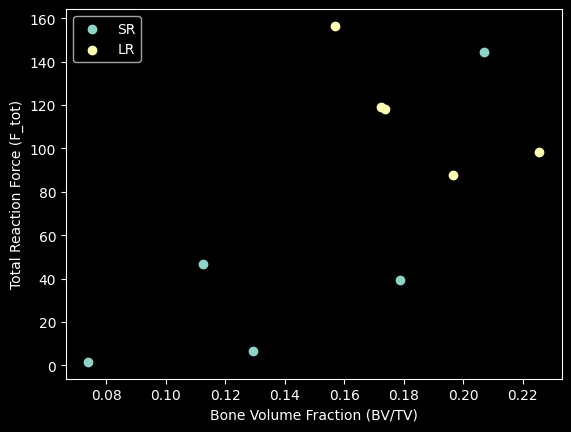

In [92]:
plt.scatter(df_results[df_results['source'] == 'SR']['BVTV'], df_results[df_results['source'] == 'SR']['F_tot'], label='SR')
plt.scatter(df_results[df_results['source'] == 'LR']['BVTV'], df_results[df_results['source'] == 'LR']['F_tot'], label='LR')
plt.xlabel('Bone Volume Fraction (BV/TV)')
plt.ylabel('Total Reaction Force (F_tot)')
plt.legend(loc='upper left')
# plt.title('F_tot vs Bone Volume Fraction for SR models')

/tmp/ipykernel_1671151/3885830972.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('SR', 'LR')


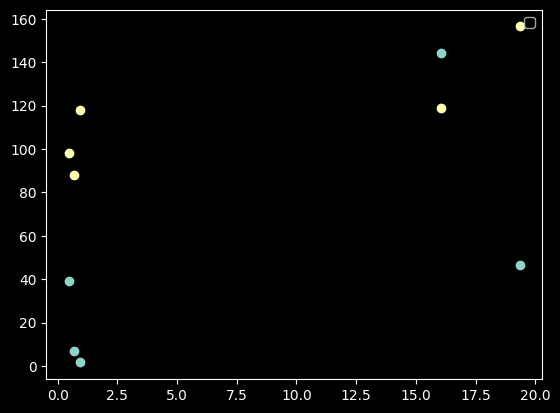

In [ ]:
plt.scatter(df_results[df_results['scale'] == 'hr']['F_tot'], df_results[df_results['scale'] == 'sr']['F_tot'])
plt.scatter(df_results[df_results['scale'] == 'hr']['F_tot'], df_results[df_results['scale'] == 'lr']['F_tot'])
plt.legend('SR', 'LR')

### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [13]:
voxel_size_mm=0.0303
cube_size = 256
topDisplacement=-0.004 * cube_size * voxel_size_mm

A = (cube_size*voxel_size_mm)**2 # [mm2]
epsilon = np.abs(topDisplacement)/(cube_size*voxel_size_mm)

In [14]:
print(topDisplacement)

-0.0310272


In [17]:
print((df_results[df_results['scale'] == 'hr']['F_tot']/A)/epsilon)

0     3.809135
1    80.394552
2     2.749475
3     1.919317
4    66.644028
Name: F_tot, dtype: float64
